# OCR Tutorial

In this tutorial, you will learn how to use OCR (EasyOCR) to detect text from Aria frames.


### Notebook stuck?
Note that because of Jupyter issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

## Step 1. Install Project Aria Tools
Run the following cell to install Project Aria Tools for reading Aria recordings in .vrs format

In [1]:
# Specifics for Google Colab
google_colab_env = 'google.colab' in str(get_ipython())
print("Running from Google Colab, installing projectaria_tools")
!pip install projectaria-tools

Running from Google Colab, installing projectaria_tools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.8 MB/s eta 0:00:00


## Step 2. Prepare an Aria recording

We will set the vrsfile path to your collected Aria recording.

Upload your Aria recording in your Google Drive before running the cell.

Here, we assume it is uploaded to **`My Drive/Fridge/87327912-42f4-4295-8f24-ceac8912d9ec.vrs`**

*(You can check the content of the mounted drive by running `!ls "/content/drive/My Drive/"` in a cell.)*



In [2]:
from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/content/drive/')
my_vrs_file_path = 'Fridge/87327912-42f4-4295-8f24-ceac8912d9ec.vrs'
vrsfile = "/content/drive/My Drive/" + my_vrs_file_path
print(f"INFO: vrsfile set to {vrsfile}")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive/
INFO: vrsfile set to /content/drive/My Drive/Fridge/87327912-42f4-4295-8f24-ceac8912d9ec.vrs


## Step 3. Create data provider

Create projectaria data_provider so you can load the content of the vrs file.

In [3]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt

print(f"Creating data provider from {vrsfile}")
provider = data_provider.create_vrs_data_provider(vrsfile)
if not provider:
    print("Invalid vrs data provider")

Creating data provider from /content/drive/My Drive/Fridge/87327912-42f4-4295-8f24-ceac8912d9ec.vrs


## Step 4. Display VRS rgb content in thumbnail images

Goals:
- Summarize a VRS using 20 image side by side, to visually inspect the collected data.

Key learnings:
- Image streams are identified with a Unique Identifier: stream_id
- Image frames are identified with timestamps
- PIL images can be created from Numpy array

Customization
- To change the number of sampled images, change the variable `sample_count` to a desired number.
- To change the thumbnail size, change the variable `resize_ratio` to a desired value.

100%|██████████| 30/30 [00:04<00:00,  6.60it/s]


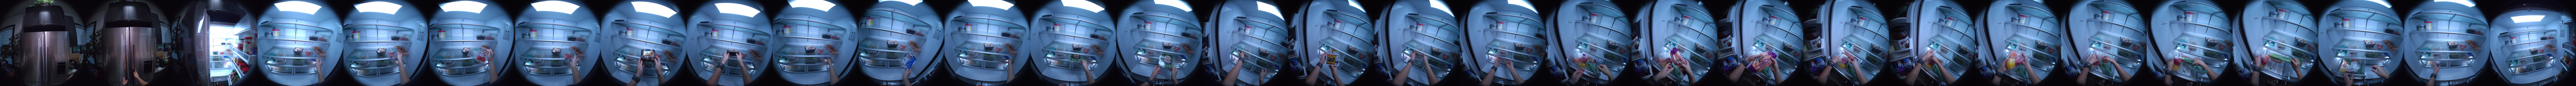

In [23]:
from PIL import Image
from tqdm import tqdm

sample_count = 30
resize_ratio = 10

rgb_stream_id = StreamId("214-1")

# Retrieve image size for the RGB stream
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = provider.get_last_time_ns(rgb_stream_id, time_domain)

image_config = provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height

thumbnail = newImage = Image.new(
    "RGB", (int(width * sample_count / resize_ratio), int(height / resize_ratio))
)
current_width = 0


# Samples 10 timestamps
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in tqdm(sample_timestamps):
    image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    image_array = image_tuple[0].to_numpy_array()
    image = Image.fromarray(image_array)
    new_size = (
        int(image.size[0] / resize_ratio),
        int(image.size[1] / resize_ratio),
    )
    image = image.resize(new_size).rotate(-90)
    thumbnail.paste(image, (current_width, 0))
    current_width = int(current_width + width / resize_ratio)

from IPython.display import Image
display(thumbnail)

## Step 5. Install EasyOCR


In [5]:
# Install detectron2
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 23.6 MB/s eta 0:00:00


## Step 6. Run OCR

Run OCR for each sampled timestamps in Step 4.

- The detected text will be stored in `ocr_dict`.

- You can set the image size using the `imsize` variable.

- You can add list of languages to be parsed as follows:
```
reader = easyocr.Reader(['en', 'fr', 'ch_sim'])
```
For all supported languages in EasyOCR, see https://www.jaided.ai/easyocr/.


- The output will be in a list format, each item represents a bounding box, the text detected and confident level, respectively.
```
[ ([[226, 170], [414, 170], [414, 220], [226, 220]], 'Yuyuan Rd.', 0.8261902332305908),
 ([[79, 173], [125, 173], [125, 213], [79, 213]], 'W', 0.9848111271858215),
 ([[529, 173], [569, 173], [569, 213], [529, 213]], 'E', 0.8405593633651733)]
 ```


In [26]:
import easyocr
from PIL import Image

imsize = 3072

ocr_dict = {
    'timestamps': [],
    'texts': [],
    'bboxes': [],
    'confidences': [],
}

reader = easyocr.Reader(['en',])  # Load EasyOCR model. Only need to be called once.

for sample in tqdm(sample_timestamps):

    # Fetch image
    image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    image_array = image_tuple[0].to_numpy_array()
    image = Image.fromarray(image_array)
    new_size = (imsize, imsize)
    image = np.asarray(image.resize(new_size).rotate(-90))
    result = reader.readtext(image)
    print(f"result: {result}")

    if result is not None:
      ocr_dict['timestamps'].append(sample)
      ocr_dict['bboxes'].append([res[0] for res in result])
      ocr_dict['texts'].append([res[1] for res in result])
      ocr_dict['confidences'].append([res[2] for res in result])


  3%|▎         | 1/30 [00:01<00:49,  1.72s/it]

result: []


  7%|▋         | 2/30 [00:03<00:52,  1.89s/it]

result: [([[1932, 1204], [2224, 1204], [2224, 1237], [1932, 1237]], 'Glataatkel', 0.0014731105990302624)]


 10%|█         | 3/30 [00:05<00:52,  1.93s/it]

result: []


 13%|█▎        | 4/30 [00:07<00:51,  1.98s/it]

result: [([[1374, 782], [1440, 782], [1440, 806], [1374, 806]], 'Jo', 0.022576198962485125), ([[501, 2070], [547, 2070], [547, 2107], [501, 2107]], 'T7', 0.0436590877383998), ([[1340.2820418413824, 761.1333087875939], [1442.9964802475656, 772.8813972130159], [1439.7179581586176, 790.8666912124061], [1338.0035197524344, 779.1186027869841]], 'A', 0.0727285687011694), ([[1338.1401328392153, 776.1942789623521], [1379.9316856744692, 782.4817428678253], [1377.8598671607847, 800.8057210376479], [1335.0683143255308, 794.5182571321747]], '7', 0.1732705053332353)]


 17%|█▋        | 5/30 [00:09<00:47,  1.90s/it]

result: [([[1156, 780], [1267, 780], [1267, 807], [1156, 807]], 'AcTiVESMART', 0.37677526174560977), ([[1158, 797], [1265, 797], [1265, 824], [1158, 824]], 'TEchnOLoGY', 0.1355612475475028), ([[137, 1299], [239, 1299], [239, 1343], [137, 1343]], 'HLADELpHIa', 0.0906552174964972), ([[388, 2195], [442, 2195], [442, 2235], [388, 2235]], '%67', 0.39587956314529754), ([[1757.4343145750508, 1773.0402020253553], [1784.3902856961254, 1757.0190858995202], [1836.5656854249492, 1850.9597979746447], [1809.6097143038746, 1866.9809141004798]], '0', 0.23576521421000507)]


 20%|██        | 6/30 [00:11<00:45,  1.89s/it]

result: [([[1141, 757], [1249, 757], [1249, 776], [1141, 776]], 'ActiveshaRT', 0.47292534027769917), ([[1141, 769], [1250, 769], [1250, 795], [1141, 795]], 'TECHNOLOGY', 0.5505183915535743), ([[118, 1281], [222, 1281], [222, 1325], [118, 1325]], 'MDELphia', 0.14488024183010614), ([[371, 2172], [432, 2172], [432, 2217], [371, 2217]], '%7', 0.7534285402525898), ([[502.97191949374644, 1181.552263139369], [575.3768512609912, 1170.855967453339], [579.0280805062536, 1205.447736860631], [505.6231487390088, 1215.144032546661]], 'MNRG', 0.027957674115896225), ([[1637.1644588494623, 1726.0703072118276], [1734.929279233349, 1751.1620225303307], [1721.8355411505377, 1794.9296927881724], [1625.070720766651, 1769.8379774696693]], 'Stghattng;', 0.32009433910670576), ([[1745.5755342621549, 1764.0150330963827], [1989.8843664630901, 1864.8277238686812], [1966.4244657378451, 1916.9849669036173], [1722.1156335369099, 1816.1722761313188]], "CAMPARI'", 0.8190299967877521), ([[1665.3273272060037, 1816.116516

 23%|██▎       | 7/30 [00:13<00:42,  1.86s/it]

result: [([[1328, 765], [1438, 765], [1438, 795], [1328, 795]], 'ActineskaRt', 0.22208666007637634), ([[1336, 782], [1436, 782], [1436, 812], [1336, 812]], 'EC-Rologt', 0.1708332886734502), ([[1962, 1878], [1981, 1878], [1981, 1904], [1962, 1904]], '9', 0.2392748244865892), ([[508, 2118], [562, 2118], [562, 2163], [508, 2163]], '37', 0.19477035080805988), ([[1940.6386286971076, 1785.0130760200855], [1974.3043128522527, 1772.0092692230542], [2031.3613713028924, 1932.9869239799145], [1997.6956871477473, 1945.9907307769458]], '6', 0.11241108044623971), ([[1945.3859944401545, 1845.0965827644789], [1962.473912360382, 1840.0569593224338], [1974.6140055598455, 1879.9034172355211], [1957.526087639618, 1884.9430406775662]], '3', 0.326667576182448)]


 27%|██▋       | 8/30 [00:15<00:41,  1.89s/it]

result: [([[260, 1311], [298, 1311], [298, 1328], [260, 1328]], 'Harn', 0.379550576210022), ([[1618, 1868], [1746, 1868], [1746, 1924], [1618, 1924]], 'Guan', 0.9995612502098083), ([[1572, 1922], [1857, 1922], [1857, 1955], [1572, 1955]], 'Baby Bella Mushrooms', 0.8780222685130796), ([[1575, 1950], [1673, 1950], [1673, 1969], [1575, 1969]], 'bebe bella cham', 0.5217156918561643), ([[760, 1984], [809, 1984], [809, 2023], [760, 2023]], 'Da', 0.16882608222909534), ([[1702.435667352017, 818.0812689968575], [1804.0, 837.0], [1799.564332647983, 855.9187310031425], [1697.0, 837.0]], 'ACTIvESMART', 0.20663623090169728), ([[1701.4199852094343, 835.0859511911331], [1800.9999000074993, 852.980000999925], [1796.5800147905657, 871.9140488088669], [1697.0000999925007, 854.019999000075]], 'Technology', 0.2990386810446727), ([[691.2446104253995, 1137.0719742120775], [813.9743385672723, 1159.5476362606357], [805.7553895746005, 1196.9280257879225], [683.0256614327277, 1174.4523637393643]], 'ladelphia', 

 30%|███       | 9/30 [00:17<00:39,  1.90s/it]

result: [([[690, 1183], [803, 1183], [803, 1231], [690, 1231]], 'HLadelphia', 0.11077479393149904), ([[171, 1362], [197, 1362], [197, 1378], [171, 1378]], 'WA', 0.28991260513055717), ([[275, 1362], [313, 1362], [313, 1378], [275, 1378]], 'Han', 0.8851351141929626), ([[157, 1383], [185, 1383], [185, 1402], [157, 1402]], 'and', 0.896506775217029), ([[267, 1383], [293, 1383], [293, 1395], [267, 1395]], 'oor', 0.05337001173894234), ([[107, 1389], [156, 1389], [156, 1414], [107, 1414]], 'Cancer', 0.861740381806778), ([[777, 1996], [828, 1996], [828, 2035], [777, 2035]], '%7', 0.4659206086852323), ([[1660.3675444679664, 826.102633403899], [1759.9995920032597, 841.9596042019543], [1756.6324555320336, 859.897366596101], [1657.0004079967403, 844.0403957980457]], 'ActiveshaRT', 0.3470501493852268), ([[1657.3675444679664, 841.102633403899], [1757.99960011996, 856.9600079976008], [1753.6324555320336, 874.897366596101], [1654.00039988004, 859.0399920023992]], 'TECHNOLOGT', 0.592921736215117), ([[19

 33%|███▎      | 10/30 [00:18<00:37,  1.88s/it]

result: [([[574, 1030], [630, 1030], [630, 1060], [574, 1060]], 'MMF', 0.01732956295092007), ([[166, 1106], [272, 1106], [272, 1148], [166, 1148]], 'MdELpha', 0.2412957273472151), ([[366, 2025], [423, 2025], [423, 2064], [366, 2064]], 'St', 0.1319017042993645), ([[1242.3859944401545, 646.0965827644789], [1351.999242918103, 661.9449749655568], [1348.6140055598455, 680.9034172355211], [1239.000757081897, 665.0550250344432]], 'ACTIvESMART', 0.3790811747408891), ([[1242.435667352017, 661.0812689968575], [1349.9996507160295, 678.9626233511023], [1345.564332647983, 698.9187310031425], [1239.0003492839705, 681.0373766488977]], 'TECHNOLOGY', 0.41161677700261096)]


 37%|███▋      | 11/30 [00:21<00:37,  1.98s/it]

result: [([[177, 1782], [231, 1782], [231, 1822], [177, 1822]], '%7', 0.31013521379278647), ([[1834, 2088], [1883, 2088], [1883, 2144], [1834, 2144]], '&', 0.44337612425806583), ([[1783, 2198], [1811, 2198], [1811, 2229], [1783, 2229]], 'X', 0.1343463609096398), ([[1701.252778313375, 1916.1448289159657], [1718.5257912011477, 1927.7069566091968], [1673.747221686625, 1991.8551710840343], [1656.4742087988523, 1980.2930433908032]], '1', 0.10617609253529636), ([[1885.4976792543355, 2024.03166610925], [1918.0891587000365, 2039.4589178435185], [1882.5023207456645, 2110.96833389075], [1849.9108412999635, 2095.5410821564815]], '3', 0.26160334936230356), ([[1586.9455026426103, 2031.1414983059149], [1618.4038444175271, 2045.8028869246891], [1545.0544973573897, 2199.858501694085], [1513.5961555824729, 2185.197113075311]], 'A', 0.13989651914883794), ([[1705.6403084639123, 2140.238186750157], [1732.3558451481106, 2158.823235579604], [1678.3596915360877, 2230.761813249843], [1651.6441548518894, 2211.

 40%|████      | 12/30 [00:23<00:36,  2.01s/it]

result: [([[538, 1010], [654, 1010], [654, 1054], [538, 1054]], 'hadelphia', 0.2879938183314362), ([[698, 1841], [746, 1841], [746, 1874], [698, 1874]], '%at', 0.2897005493903599), ([[1544.3273272060037, 598.1165161768104], [1649.9985503305154, 611.9238647493137], [1646.6726727939963, 629.8834838231896], [1541.0014496694846, 616.0761352506863]], 'AcTivEShART', 0.17751561167098565), ([[1542.3675444679664, 612.102633403899], [1646.9966798833511, 625.8848069298067], [1643.6324555320336, 645.897366596101], [1539.0033201166489, 632.1151930701933]], 'TECHNOLOGY', 0.4999507129738482)]


 43%|████▎     | 13/30 [00:25<00:34,  2.02s/it]

result: [([[615, 993], [750, 993], [750, 1045], [615, 1045]], 'Qhdelpha', 0.26770590830402713), ([[205, 1196], [243, 1196], [243, 1215], [205, 1215]], 'Ham', 0.10971083564881662), ([[765, 1852], [819, 1852], [819, 1891], [765, 1891]], '%2', 0.6690987489482378), ([[1579, 1942], [1705, 1942], [1705, 1978], [1579, 1978]], 'cr9t', 0.04130375757813454), ([[1541, 1965], [1742, 1965], [1742, 2033], [1541, 2033]], 'MAruadrsh"', 0.03239510407616148), ([[1609, 2061], [1714, 2061], [1714, 2091], [1609, 2091]], 'Wto0z(14201', 0.1834236028126205), ([[1641.4505577442053, 628.0769521047183], [1745.9996372869032, 647.9619116707256], [1741.5494422557947, 666.9230478952817], [1637.0003627130968, 646.0380883292744]], 'ActiveshART', 0.2581030897745465), ([[1638.4505577442053, 643.0769521047183], [1740.99990389005, 662.9803930991171], [1736.5494422557947, 681.9230478952817], [1635.00009610995, 662.0196069008829]], 'Technology', 0.21879412150288638), ([[102.00992561958002, 1203.800992561958], [176.766924204

 47%|████▋     | 14/30 [00:27<00:31,  1.94s/it]

result: [([[1780.4478423696257, 2029.0305813266318], [1931.9809685874807, 2085.5641652485956], [1913.5521576303743, 2128.969418673368], [1762.0190314125193, 2072.4358347514044]], 'Onyanc', 0.1237886591207393), ([[1786.227268514136, 2092.0499675588485], [1887.9757985460878, 2130.4616397706227], [1867.772731485864, 2180.9500324411515], [1765.0242014539122, 2141.5383602293773]], '4', 0.31834307765370795)]


 50%|█████     | 15/30 [00:28<00:28,  1.93s/it]

result: [([[906, 1117], [975, 1117], [975, 1133], [906, 1133]], 'WARNING:', 0.8991113843800745), ([[843, 1134], [1028, 1134], [1028, 1153], [843, 1153]], 'Cancer and Reproductive Harm', 0.5292940419620022), ([[860, 1153], [1011, 1153], [1011, 1169], [860, 1169]], 'WMWp6Swamingscagov', 0.1881640374512279), ([[2346.592091491776, 784.0420391605248], [2452.9837044175056, 816.7452122766507], [2446.407908508224, 835.9579608394752], [2340.0162955824944, 803.2547877233493]], 'AcTiveshaRT', 0.28648745426484773), ([[2340.58378471107, 800.0437881420303], [2444.9875398977542, 830.7770983292238], [2438.41621528893, 850.9562118579697], [2334.0124601022458, 819.2229016707762]], 'Technology', 0.5226220596831812), ([[1347.3729298231972, 1019.0494578861421], [1463.9987711422966, 1052.9008569138273], [1451.6270701768028, 1089.9505421138579], [1335.0012288577034, 1056.0991430861727]], 'MHLAdELPhia', 0.09352867593718474), ([[23.51467491880056, 1776.0395170046834], [128.9579283436804, 1695.7270027274515], [

 53%|█████▎    | 16/30 [00:30<00:27,  1.95s/it]

result: [([[931, 900], [1094, 900], [1094, 932], [931, 932]], 'Cancer and Reproductive', 0.7946185268188937), ([[947, 920], [1085, 920], [1085, 950], [947, 950]], 'WWWP6Swarnings ca ', 0.27305575133463633), ([[1081, 935], [1107, 935], [1107, 949], [1081, 949]], '90v', 0.2644509213355064), ([[1374, 1643], [1419, 1643], [1419, 1687], [1374, 1687]], '9', 0.6838140897345966), ([[1631, 1773], [1687, 1773], [1687, 1815], [1631, 1815]], '3', 0.9290150215892403), ([[1488, 2014], [1615, 2014], [1615, 2050], [1488, 2050]], 'FTRADER JoE" $', 0.15794308167966667), ([[1464, 2248], [1603, 2248], [1603, 2285], [1464, 2285]], 'NET WT 14 02 (3969)', 0.468117465729898), ([[436, 2447], [483, 2447], [483, 2484], [436, 2484]], 'S', 0.004153081699360905), ([[1465.2828546384055, 815.0516970049982], [1589.9998497754143, 853.9612414746092], [1576.7171453615945, 893.9483029950018], [1451.0001502245857, 855.0387585253908]], 'phhadelphia _', 0.12482436950577731), ([[1000.2820418413822, 884.1333087875939], [1072.9

 57%|█████▋    | 17/30 [00:32<00:24,  1.92s/it]

result: [([[877, 1031], [951, 1031], [951, 1049], [877, 1049]], 'WARNING:', 0.6782623551199493), ([[809, 1046], [1007, 1046], [1007, 1072], [809, 1072]], 'Cancer and Reproductlve Harm', 0.6319937193437553), ([[829, 1069], [989, 1069], [989, 1085], [829, 1085]], 'WMwp6Swamings C} 904', 0.05861992812878405), ([[1297, 1749], [1344, 1749], [1344, 1793], [1297, 1793]], '98', 0.1135125209292214), ([[2390.575140711338, 705.0456472721544], [2495.983097316774, 736.7405293230389], [2489.424859288662, 754.9543527278456], [2385.016902683226, 723.2594706769611]], 'ACTIvEShART', 0.3143323250997273), ([[1344.3729298231972, 935.0494578861421], [1465.9988484974253, 968.9040276360618], [1453.6270701768028, 1005.9505421138579], [1333.0011515025747, 972.0959723639382]], 'phhladelphia', 0.49889728103412034)]


 60%|██████    | 18/30 [00:34<00:23,  1.94s/it]

result: [([[2197, 575], [2230, 575], [2230, 589], [2197, 589]], 'Os', 0.17141918573980716), ([[1120, 916], [1256, 916], [1256, 970], [1120, 970]], 'MhHLAdElphia', 0.08332469900470227), ([[594, 1117], [653, 1117], [653, 1143], [594, 1143]], 'Cancer ', 0.6320807329890166), ([[1228, 1751], [1277, 1751], [1277, 1788], [1228, 1788]], '97', 0.12718062184870296), ([[2131.4647122724277, 542.0729641807401], [2240.999256613021, 562.9454748196449], [2236.5352877275723, 581.9270358192599], [2127.000743386979, 560.0545251803551]], 'AcTIVESHART', 0.2893925791891137), ([[2133.282041841382, 560.1333087875939], [2203.9968335622334, 572.8875023345221], [2200.717958158618, 589.8666912124061], [2129.0031664377666, 577.1124976654779]], 'TECANOL(', 0.12734502751058266), ([[660.5857864376269, 1090.585786437627], [739.8673497071626, 1082.2837562767047], [742.4142135623731, 1103.414213562373], [663.1326502928374, 1111.7162437232953]], 'WARNING:', 0.6792164970981384), ([[762.6546544120074, 1097.5201198532081], 

 63%|██████▎   | 19/30 [00:37<00:23,  2.09s/it]

result: [([[842, 760], [933, 760], [933, 789], [842, 789]], 'WARNING:', 0.5941920848187636), ([[767, 793], [829, 793], [829, 814], [767, 814]], 'Cencer', 0.5197191354894142), ([[861, 786], [1000, 786], [1000, 811], [861, 811]], 'Reproductive Ham', 0.3701833272379305), ([[790, 803], [982, 803], [982, 841], [790, 841]], 'Vw# P6swarningscagoi', 0.02431355020546204), ([[1383, 1572], [1434, 1572], [1434, 1621], [1383, 1621]], '%8', 0.1659409632000858), ([[1590, 2053], [1621, 2053], [1621, 2072], [1590, 2072]], '07', 0.6818916004100913), ([[1373.1780050634732, 628.0680303808393], [1516.9768561009482, 655.5194759626671], [1506.8219949365268, 697.9319696191607], [1362.0231438990518, 670.4805240373329]], 'PHULAdeLphia', 0.23536653724599102), ([[824.8375236125618, 792.3725330575866], [859.6128099917114, 788.8172726727449], [861.1624763874382, 809.6274669424134], [826.3871900082886, 813.1827273272551]], 'Yand', 0.1945338249206543), ([[1491.2968374460654, 2014.062289697966], [1593.999288192894, 20

 67%|██████▋   | 20/30 [00:39<00:21,  2.20s/it]

result: [([[1045, 726], [1132, 726], [1132, 758], [1045, 758]], 'Cancer ond', 0.8428132409478463), ([[148, 1463], [216, 1463], [216, 1538], [148, 1538]], 'a', 0.060660121169304526), ([[1476, 1558], [1525, 1558], [1525, 1609], [1476, 1609]], '%2', 0.14300148619776196), ([[361, 2441], [459, 2441], [459, 2485], [361, 2485]], 'JNe', 0.005408981805752671), ([[1607.3720990679194, 655.0395826365625], [1743.996946415418, 701.8252815938665], [1728.6279009320806, 743.9604173634375], [1591.003053584582, 697.1747184061335]], 'PhHLAdElphia', 0.284783325475064), ([[1118.1535010280254, 709.1219034952862], [1199.9683831924024, 722.5656024596484], [1194.8464989719746, 748.8780965047138], [1112.0316168075976, 735.4343975403516]], 'WARNING:', 0.833253961877591), ([[1129.348018633361, 738.1092540367474], [1219.9921452813853, 749.8229204194324], [1216.651981366639, 770.8907459632526], [1126.0078547186147, 758.1770795805676]], 'Reproductive /', 0.66004267051669), ([[1215.1401328392153, 750.1942789623521], [

 70%|███████   | 21/30 [00:41<00:19,  2.22s/it]

result: [([[1314, 771], [1345, 771], [1345, 790], [1314, 790]], 'Rem', 0.1346024918294949), ([[1561, 1533], [1606, 1533], [1606, 1575], [1561, 1575]], '%', 0.30148375652294135), ([[1544, 2106], [1573, 2106], [1573, 2125], [1544, 2125]], 'Oy', 0.16381910211062992), ([[1365, 2179], [1428, 2179], [1428, 2251], [1365, 2251]], '0', 0.17370978737236342), ([[1537, 2188], [1575, 2188], [1575, 2225], [1537, 2225]], '7G', 0.0037538438283366616), ([[1717, 2349], [1759, 2349], [1759, 2388], [1717, 2388]], 'Qo', 0.18305005629445134), ([[1677.339181399545, 664.0438604965868], [1809.9998687302275, 706.9637690671723], [1794.660818600455, 748.9561395034132], [1662.0001312697725, 706.0362309328277]], 'phlladelphia', 0.19737456482181914), ([[1227.257218647292, 738.1430466182295], [1296.9793211980007, 746.7131418553622], [1293.742781352708, 766.8569533817705], [1224.0206788019993, 757.2868581446378]], 'WaRNING', 0.509676082231689), ([[1163.2820418413824, 752.1333087875939], [1238.9824558013652, 761.735672

 73%|███████▎  | 22/30 [00:43<00:17,  2.15s/it]

result: [([[1330, 776], [1400, 776], [1400, 804], [1330, 804]], 'WARNING:', 0.4913763503812993), ([[1265, 790], [1420, 790], [1420, 828], [1265, 828]], 'Cancer and Reproductive }', 0.3364949235476678), ([[1636, 1569], [1680, 1569], [1680, 1613], [1636, 1613]], '%', 0.4140462632325672), ([[594, 2368], [699, 2368], [699, 2410], [594, 2410]], 'Mesp', 0.16989509761333466), ([[1770.3214058935425, 704.0462630228603], [1903.0, 745.0], [1888.6785941064575, 786.9537369771397], [1755.0, 745.0]], 'PhHLAdELphIa', 0.19925876072805965), ([[1415.105572809, 807.2111456180002], [1447.8913731986097, 812.3498404629779], [1444.894427191, 830.7888543819998], [1412.1086268013903, 824.6501595370221]], 'Kyrm', 0.37151896953582764), ([[1285.4199852094343, 812.0859511911331], [1430.9995720755476, 828.9586295432646], [1427.5800147905657, 848.9140488088669], [1282.0004279244524, 832.0413704567354]], 'WW p6Swarnngs cagov', 0.22506200242372462), ([[402.39177126298426, 1440.0465132093975], [562.0263197157396, 1348.3

 77%|███████▋  | 23/30 [00:45<00:14,  2.10s/it]

result: [([[1680, 1575], [1729, 1575], [1729, 1624], [1680, 1624]], '%', 0.1696456388490475), ([[635, 2369], [744, 2369], [744, 2420], [635, 2420]], '015s42', 0.0071135542511897), ([[1843.3720990679194, 705.0395826365625], [1978.9920839055837, 753.7187558363051], [1962.6279009320806, 793.9604173634375], [1827.0079160944163, 746.2812441636949]], 'philadelphIa ', 0.12176504582188466), ([[1415.3273272060037, 768.1165161768104], [1479.9850220218273, 779.7556895973136], [1475.6726727939963, 799.8834838231896], [1411.0149779781727, 788.2443104026864]], 'WARNNG', 0.2707117717840791), ([[1352.2820418413824, 783.1333087875939], [1423.9874237306651, 793.7760649317561], [1420.7179581586176, 812.8666912124061], [1349.0125762693349, 802.2239350682439]], 'Cancet and[', 0.4546211307401828), ([[1420.348018633361, 791.1092540367474], [1495.9915702175244, 803.8165659010175], [1492.651981366639, 823.8907459632526], [1416.0084297824756, 811.1834340989825]], 'Repraxor', 0.03908685453567249), ([[1365.491013

 80%|████████  | 24/30 [00:47<00:12,  2.07s/it]

result: [([[851, 801], [938, 801], [938, 829], [851, 829]], 'Warte', 0.03198088692346221), ([[780, 826], [1002, 826], [1002, 854], [780, 854]], 'Cancerand Reprnktterm', 0.004224943080893857), ([[873, 847], [984, 847], [984, 873], [873, 873]], 'Ratanest497', 0.034741620384671476), ([[1256, 1542], [1287, 1542], [1287, 1563], [1256, 1563]], 'Du', 0.45718670252096166), ([[1381, 1590], [1431, 1590], [1431, 1632], [1381, 1632]], '%2', 0.21400946164205062), ([[1363.1911248646677, 664.0658616744723], [1504.9794660323385, 692.5473212697874], [1494.8088751353323, 734.9341383255277], [1352.0205339676615, 706.4526787302126]], 'phuladelphia', 0.20065410285384513), ([[802.5134117075056, 859.6620705367551], [878.8477119272127, 850.2345193444404], [881.4865882924944, 871.3379294632449], [805.1522880727873, 880.7654806555596]], 'nnnpos', 0.02899354089647742), ([[1240.435667352017, 1544.0812689968575], [1296.999712788108, 1562.9661065629134], [1289.564332647983, 1581.9187310031425], [1234.000287211892, 

 83%|████████▎ | 25/30 [00:49<00:10,  2.06s/it]

result: [([[1314, 620], [1335, 620], [1335, 632], [1314, 632]], 'On', 0.764776418455335), ([[698, 707], [796, 707], [796, 744], [698, 744]], 'WARNING;', 0.7374712011641751), ([[681, 732], [869, 732], [869, 768], [681, 768]], 'Tand Reproductive Harm', 0.44394470438129846), ([[620, 747], [689, 747], [689, 774], [620, 774]], 'Cancer', 0.9998574521067147), ([[798, 759], [848, 759], [848, 778], [798, 778]], 'ca gov', 0.7861935859789547), ([[648, 756], [803, 756], [803, 797], [648, 797]], 'Www p6Swarnings c', 0.32758680980407634), ([[1319, 1521], [1371, 1521], [1371, 1565], [1319, 1565]], '%7', 0.3653880479884173), ([[1252.1504654174619, 550.0726994212782], [1400.9549621520516, 573.330410519993], [1391.8495345825381, 617.9273005787218], [1243.0450378479484, 594.669589480007]], 'PhHLAdELphIa', 0.120850789474285), ([[1188.257218647292, 1472.1430466182294], [1225.9685424139877, 1482.6466718744125], [1220.742781352708, 1500.8569533817706], [1183.0314575860123, 1490.3533281255875]], '4I', 0.02668

 87%|████████▋ | 26/30 [00:52<00:08,  2.12s/it]

result: [([[1141, 605], [1301, 605], [1301, 666], [1141, 666]], 'PhlAdelphia', 0.2877759422632685), ([[1185, 649], [1241, 649], [1241, 689], [1185, 689]], 'chion', 0.5316763881897328), ([[702, 851], [735, 851], [735, 872], [702, 872]], 'gov', 0.9801883626710868), ([[1285, 1593], [1339, 1593], [1339, 1637], [1285, 1637]], '%7', 0.513147409869778), ([[572.8786796564403, 816.8786796564403], [675.8015702550884, 804.9270582001789], [678.1213203435597, 831.1213203435597], [576.1984297449116, 843.0729417998211]], 'WARNING:', 0.9954722134171441), ([[706.7805784783006, 826.4147520217908], [754.7804963259547, 822.089048391372], [755.2194215216994, 842.5852479782092], [708.2195036740453, 845.910951608628]], 'Harm', 0.9965488910675049), ([[593.4275212228624, 840.4565127337174], [710.7872063439454, 822.8902789556513], [714.5724787771376, 849.5434872662826], [597.2127936560546, 868.1097210443487]], 'Reproductive [', 0.43483786413867936), ([[555.2562854188427, 847.5587995863798], [598.1845999780784, 

 90%|█████████ | 27/30 [00:54<00:06,  2.18s/it]

result: [([[1417, 548], [1465, 548], [1465, 567], [1417, 567]], 'Ohion', 0.47403824519568655), ([[816, 617], [911, 617], [911, 642], [816, 642]], 'WARNING:', 0.9760419671726335), ([[729, 639], [987, 639], [987, 675], [729, 675]], 'Cancer and Reproductive Harm', 0.9970173206993416), ([[754, 663], [966, 663], [966, 701], [754, 701]], 'wwwp6Swarnings cagov', 0.5217013768610158), ([[1402, 1503], [1458, 1503], [1458, 1552], [1402, 1552]], '%7', 0.2966544926425452), ([[1375.127036057031, 471.0638451878109], [1537.9553382453994, 500.2692836508713], [1525.872963942969, 550.9361548121891], [1363.0446617546006, 521.7307163491288]], 'phLAdELphIa', 0.408713482592662), ([[1413.2307692307693, 525.1538461538462], [1460.9579608394752, 533.592091491776], [1456.7692307692307, 552.8461538461538], [1409.0420391605248, 544.407908508224]], 'hve', 0.4646088287267015), ([[1265.3273272060037, 1448.1165161768104], [1305.9662600989673, 1459.634184167634], [1299.6726727939963, 1479.8834838231896], [1259.033739901

 93%|█████████▎| 28/30 [00:56<00:04,  2.14s/it]

result: [([[625, 861], [771, 861], [771, 903], [625, 903]], 'ahladelphia', 0.12361140634212421), ([[877, 1799], [934, 1799], [934, 1839], [877, 1839]], 'P7', 0.2837215220823162), ([[182.5857864376269, 1129.585786437627], [225.63638339372133, 1121.8501089665742], [229.4142135623731, 1142.414213562373], [185.36361660627867, 1150.1498910334258]], 'Har', 0.30219659386928216), ([[84.51341170750567, 1147.6620705367552], [152.60662354323225, 1121.8088825455347], [159.48658829249433, 1141.3379294632448], [91.39337645676775, 1167.1911174544653]], 'Rhing:', 0.17514943258863933), ([[87.06850713433475, 1169.230163555236], [183.66707682443334, 1131.895076988457], [189.93149286566523, 1153.769836444764], [94.33292317556668, 1191.104923011543]], 'Reproductre', 0.49614233868813923), ([[116.9859597468732, 1180.2761315696844], [208.68901715689935, 1145.9289159492832], [215.01404025312678, 1166.7238684303156], [123.31098284310065, 1200.0710840507168]], 'mingica 90y', 0.07913960730105077)]


 97%|█████████▋| 29/30 [00:58<00:02,  2.02s/it]

result: [([[497, 951], [645, 951], [645, 999], [497, 999]], 'MhLAdELphia', 0.2985666010891206), ([[623, 1881], [677, 1881], [677, 1905], [623, 1905]], 'Ko1jt', 0.047324148910154816), ([[784, 1878], [843, 1878], [843, 1920], [784, 1920]], '%2', 0.42291130808247646)]


100%|██████████| 30/30 [01:00<00:00,  2.00s/it]

result: [([[1303, 1001], [1384, 1001], [1384, 1020], [1303, 1020]], 'Activeshart', 0.30961942681549165), ([[1303, 1013], [1386, 1013], [1386, 1032], [1303, 1032]], 'Technology', 0.2486261616605942), ([[861, 2161], [912, 2161], [912, 2201], [861, 2201]], '%j7', 0.1400590865226615), ([[579.6750472251236, 1495.7450661151731], [688.6956123916493, 1484.4694938580037], [690.3249527748764, 1516.2549338848269], [582.3043876083507, 1528.5305061419963]], 'MHADELPhia', 0.11381579493931482), ([[2850.563205855099, 2191.015920214855], [2894.8540145985403, 2208.401459854015], [2843.436794144901, 2339.984079785145], [2799.1459854014597, 2322.598540145985]], '8', 0.9857301846051456)]


## Step 8. Display and save detected text lists

### We can get ocr results for each timestamps.

In [27]:
ocr_save_path = '/content/ocr_results.json'

import pandas as pd
df = pd.DataFrame(ocr_dict)
df.to_json(ocr_save_path)
display(df)

timestamps                                              texts  \
0   1.641293e+12                                                 []   
1   1.642534e+12                                       [Glataatkel]   
2   1.643776e+12                                                 []   
3   1.645017e+12                                     [Jo, T7, A, 7]   
4   1.646258e+12      [AcTiVESMART, TEchnOLoGY, HLADELpHIa, %67, 0]   
5   1.647500e+12  [ActiveshaRT, TECHNOLOGY, MDELphia, %7, MNRG, ...   
6   1.648741e+12              [ActineskaRt, EC-Rologt, 9, 37, 6, 3]   
7   1.649982e+12  [Harn, Guan, Baby Bella Mushrooms, bebe bella ...   
8   1.651224e+12  [HLadelphia, WA, Han, and, oor, Cancer, %7, Ac...   
9   1.652465e+12        [MMF, MdELpha, St, ACTIvESMART, TECHNOLOGY]   
10  1.653707e+12                          [%7, &, X, 1, 3, A, 1, 1]   
11  1.654948e+12          [hadelphia, %at, AcTivEShART, TECHNOLOGY]   
12  1.656189e+12  [Qhdelpha, Ham, %2, cr9t, MAruadrsh", Wto0z(14...   
13  1.657431e+12                                        [Onyanc, 4]   
14  1.658672e+12  [WARNING:, Cancer and Reproductive Harm, WMWp6...   
15  1.659913e+12  [Cancer and Reproductive, WWWP6Swarnings ca , ...   
16  1.661155e+12  [WARNING:, Cancer and Reproductlve Harm, WMwp6...   
17  1.662396e+12  [Os, MhHLAdElphia, Cancer , 97, AcTIVESHART, T...   
18  1.663638e+12  [WARNING:, Cencer, Reproductive Ham, Vw# P6swa...   
19  1.664879e+12  [Cancer ond, a, %2, JNe, PhHLAdElphia, WARNING...   
20  1.666120e+12  [Rem, %, Oy, 0, 7G, Qo, phlladelphia, WaRNING,...   
21  1.667362e+12  [WARNING:, Cancer and Reproductive }, %, Mesp,...   
22  1.668603e+12  [%, 015s42, philadelphIa , WARNNG, Cancet and[...   
23  1.669845e+12  [Warte, Cancerand Reprnktterm, Ratanest497, Du...   
24  1.671086e+12  [On, WARNING;, Tand Reproductive Harm, Cancer,...   
25  1.672327e+12  [PhlAdelphia, chion, gov, %7, WARNING:, Harm, ...   
26  1.673569e+12  [Ohion, WARNING:, Cancer and Reproductive Harm...   
27  1.674810e+12  [ahladelphia, P7, Har, Rhing:, Reproductre, mi...   
28  1.676051e+12                           [MhLAdELphia, Ko1jt, %2]   
29  1.677293e+12      [Activeshart, Technology, %j7, MHADELPhia, 8]   

                                               bboxes  \
0                                                  []   
1   [[[1932, 1204], [2224, 1204], [2224, 1237], [1...   
2                                                  []   
3   [[[1374, 782], [1440, 782], [1440, 806], [1374...   
4   [[[1156, 780], [1267, 780], [1267, 807], [1156...   
5   [[[1141, 757], [1249, 757], [1249, 776], [1141...   
6   [[[1328, 765], [1438, 765], [1438, 795], [1328...   
7   [[[260, 1311], [298, 1311], [298, 1328], [260,...   
8   [[[690, 1183], [803, 1183], [803, 1231], [690,...   
9   [[[574, 1030], [630, 1030], [630, 1060], [574,...   
10  [[[177, 1782], [231, 1782], [231, 1822], [177,...   
11  [[[538, 1010], [654, 1010], [654, 1054], [538,...   
12  [[[615, 993], [750, 993], [750, 1045], [615, 1...   
13  [[[1780.4478423696257, 2029.0305813266318], [1...   
14  [[[906, 1117], [975, 1117], [975, 1133], [906,...   
15  [[[931, 900], [1094, 900], [1094, 932], [931, ...   
16  [[[877, 1031], [951, 1031], [951, 1049], [877,...   
17  [[[2197, 575], [2230, 575], [2230, 589], [2197...   
18  [[[842, 760], [933, 760], [933, 789], [842, 78...   
19  [[[1045, 726], [1132, 726], [1132, 758], [1045...   
20  [[[1314, 771], [1345, 771], [1345, 790], [1314...   
21  [[[1330, 776], [1400, 776], [1400, 804], [1330...   
22  [[[1680, 1575], [1729, 1575], [1729, 1624], [1...   
23  [[[851, 801], [938, 801], [938, 829], [851, 82...   
24  [[[1314, 620], [1335, 620], [1335, 632], [1314...   
25  [[[1141, 605], [1301, 605], [1301, 666], [1141...   
26  [[[1417, 548], [1465, 548], [1465, 567], [1417...   
27  [[[625, 861], [771, 861], [771, 903], [625, 90...   
28  [[[497, 951], [645, 951], [645, 999], [497, 99...   
29  [[[1303, 1001], [1384, 1001], [1384, 1020], [1...   

                                    